In [1]:
import json 
import pandas as pd
import os
import glob

with open("paper/MOFs/ABAYIO_clean-(id:831).json", "r") as f:
    data = f.read()

def mof_obj(f):
    with open(f, "r") as fil:
        data = fil.read()
    obj = json.loads(data)
    return {key : obj[key] for key in ["mofid","void_fraction","surface_area_m2g","surface_area_m2cm3","pld","lcd"]}
    
mof_obj("paper/MOFs/ABAYIO_clean-(id:831).json")

{'mofid': 'Cl[Mn][Mn]Cl.[O-]C(=O)c1cc(cc(c1)C(=O)[O-])C(=O)[O-] MOFid-v1.tbo.cat0',
 'void_fraction': 0.613197,
 'surface_area_m2g': 1301.9,
 'surface_area_m2cm3': 1235.67,
 'pld': 4.3226,
 'lcd': 11.4076}

In [6]:
import glob
MOFs = []
for f in glob.glob("paper/MOFs/*.json"):
    MOFs.append(mof_obj(f))

In [28]:
from exmoset.fingerprints import fingerprints, Fingerprint, mof_template


def pos_charged(mol):
    return 1 if "-" in mol else 0 

def aromatic_carbon(mol):
    return 1 if "c" in mol else 0

def triple_bonds(mol):
    return 1 if "#" in mol else 0

pos_charged_fingerprint = Fingerprint(property=f"Positively Charged",
                                verb="are",
                                 noun="MOFs",
                                 label_type="binary",
                                 calculator=pos_charged,
                                 mol_format="mofid")

aromatic_carbon_fingerprint = Fingerprint(property=f"Aromatic",
                                verb="are",
                                 noun="MOFs",
                                 label_type="binary",
                                 calculator=aromatic_carbon,
                                 mol_format="mofid")

triple_fp =  Fingerprint(property=f"Triple",
                                verb="contain",
                                 noun="MOFs",
                                 label_type="binary",
                                 calculator=triple_bonds,
                                 mol_format="mofid")

In [29]:
import mendeleev
atoms = [x.symbol for x in mendeleev.get_all_elements()]

In [30]:
atoms = ["Zn","Cu","P","O","C","N","H","F","B","Fe"]
def contains(atom):
    def sub_contains(mol):
        return 1 if atom in mol else 0
    return sub_contains

atom_fingerprints = []

for atom in atoms:
    atom_fingerprints.append(Fingerprint(property=f"{atom}",
                verb="contain",
                noun="Molecules",
                label_type="binary",
                calculator=contains(atom),
                mol_format="mofid"))


In [31]:
df = pd.DataFrame(MOFs)
df = df.dropna()

In [32]:
df.to_csv("exmoset/data/MOFs_Dataset.csv",index=False)

In [130]:
from exmoset import MolSpace
from exmoset.fingerprints import fingerprints, Fingerprint, mof_template
from rdkit import Chem
import numpy as np
import matplotlib.pyplot as plt

space = MolSpace(fingerprints=[aromatic_carbon_fingerprint,triple_fp]+atom_fingerprints,
                      file="exmoset/data/MOFs_Dataset.csv",
                      mol_converters={"mofid" : str},
                      index_col="mofid",
                      clusters={},
                      template_fp=mof_template)

#space.add_cluster(("Aromatic",space.data["Aromatic"] == 1))
#space.add_cluster(("LoDi",space.data["Dipole Moment"] < 0.1))
#space.add_cluster(("HiDi",space.data["Dipole Moment"] > 6))
#space.add_cluster(("LoGap",space.data["HOMO-LUMO Gap"] < 0.25))

100%|██████████| 12/12 [00:00<00:00, 499.71it/s]

Importing exmoset/data/MOFs_Dataset.csv
Converting Molecules
Calculating Properties
Generating Clusters


In [131]:
space.data

,void_fraction,surface_area_m2g,surface_area_m2cm3,pld,lcd,Aromatic,Triple,Zn,Cu,P,O,C,N,H,F,B,Fe
0,0.691684,2862.13,1920.29,7.81880,9.99521,1,0,1,0,0,1,1,1,0,1,0,0
1,0.308818,0.00,0.00,2.57347,3.94915,1,0,0,0,1,1,1,1,0,1,0,0
2,0.606919,1293.55,1607.94,4.61872,6.46856,1,0,0,0,0,1,1,1,0,1,0,0
3,0.316905,0.00,0.00,2.64045,5.53566,1,1,0,0,0,1,1,1,0,1,0,1
4,0.503607,0.00,0.00,3.27236,6.10696,1,0,0,0,0,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7015,0.887222,3936.38,1925.18,9.58261,14.34300,1,0,0,1,0,1,1,1,0,1,0,0
7016,0.723269,1228.68,1449.57,10.81980,11.37160,1,0,0,0,0,1,1,1,0,1,0,0
7017,0.218833,0.00,0.00,3.35592,4.94476,1,0,0,0,0,1,1,1,0,1,0,0
7018,0.540490,1036.25,1197.77,7.85164,8.11716,1,0,0,1,0,1,1,0,1,1,1,0


In [40]:
dims = df[["void_fraction","surface_area_m2g","surface_area_m2cm3","pld","lcd"]].to_numpy()

In [41]:
import umap 

reducer = umap.UMAP()
embedding = reducer.fit_transform(dims)

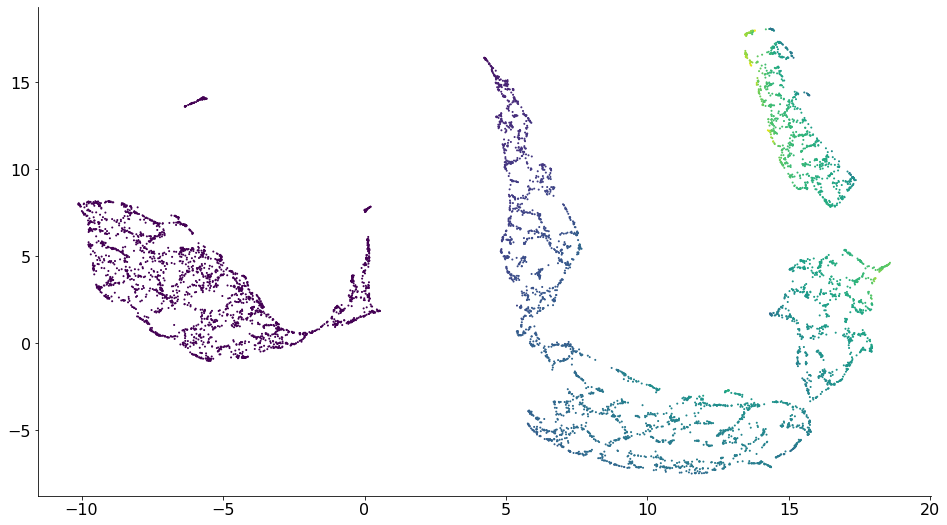

In [76]:
import matplotlib.pyplot as plt 

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],s=1,c=space.data["surface_area_m2cm3"])

Estimated number of clusters: 5
Estimated number of noise points: 0
Homogeneity: 0.001
Completeness: 0.001
V-measure: 0.001
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


Silhouette Coefficient: 0.291


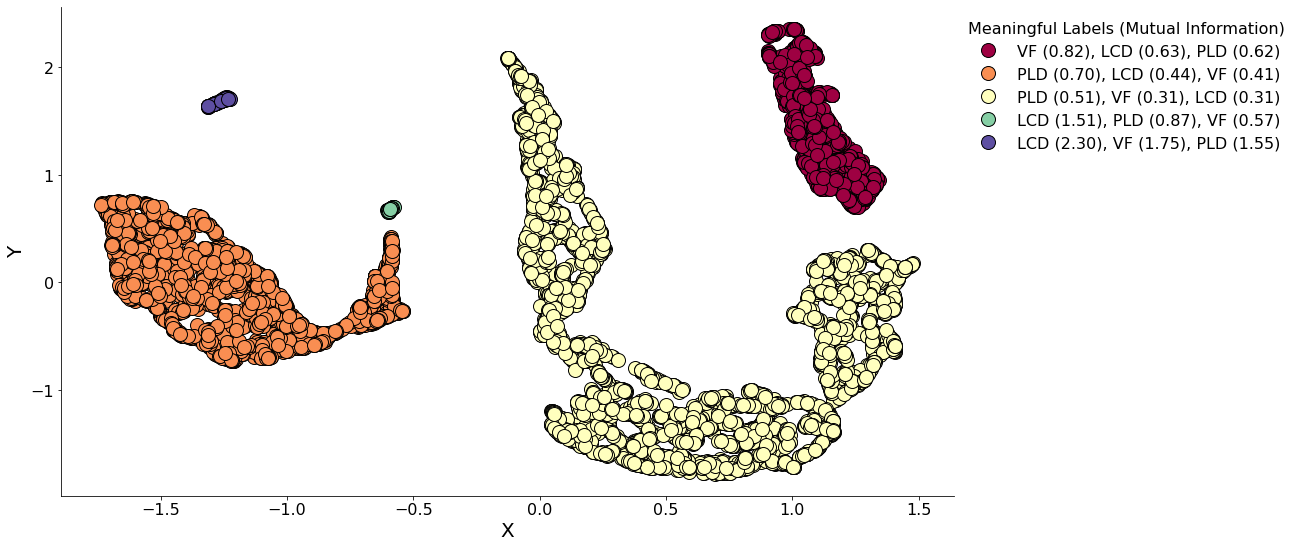

In [125]:
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = False

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=7020, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(embedding)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.2, min_samples=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

word_labels = ["VF (0.82), LCD (0.63), PLD (0.62)","PLD (0.70), LCD (0.44), VF (0.41)","PLD (0.51), VF (0.31), LCD (0.31)","LCD (1.51), PLD (0.87), VF (0.57)","LCD (2.30), VF (1.75), PLD (1.55)"]

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14, label=word_labels[int(k)])

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    
plt.title("")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(title="Meaningful Labels (Mutual Information)",title_fontsize=16,bbox_to_anchor=(1,1), loc="upper left")
plt.savefig("paper/Dimensionality_Reduced_MOF_Dataset.svg",bbox_inches="tight")
plt.show()

In [44]:
df["X1"] = embedding[:,0]
df["X2"] = embedding[:,1]

df.to_csv("Mol_Vis_df.csv")

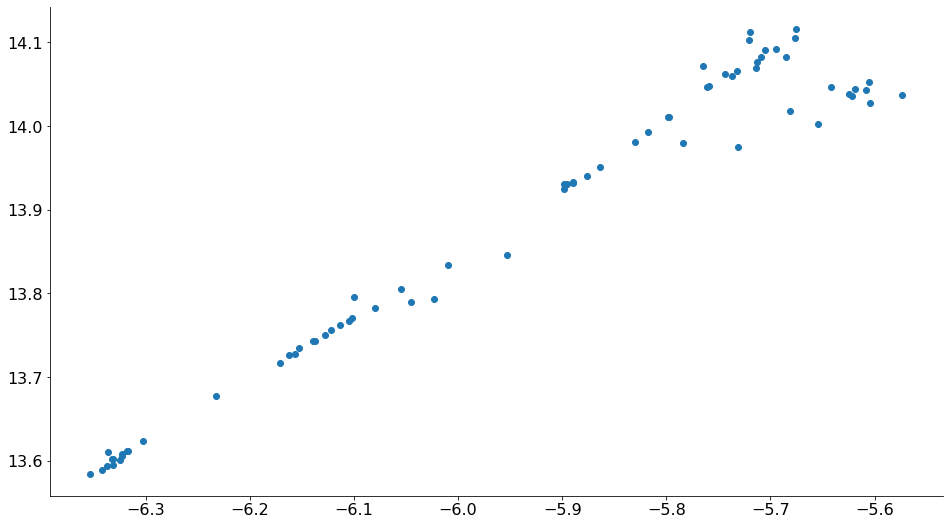

In [85]:
set_val =4
plt.scatter(embedding[db.labels_==set_val,0],embedding[db.labels_==set_val,1])

In [134]:

space.add_cluster(["DBSCAN",db.labels_])


In [114]:
for i in range(5):
    print(space.mi("DBSCAN","pld",i))

0.6224527669012083
0.7020695888002315
0.5082601600000913
0.8702845373855101
1.5505201729214413


In [115]:
word_labels = ["VF (0.82),LCD (0.63),PLD (0.62)","PLD (0.70),LCD (0.44),VF (0.41)","PLD (0.51),VF (0.31),LCD (0.31)","LCD (1.51),PLD (0.87),VF (0.57)","LCD (2.30),VF (1.75),PLD (1.55)"]

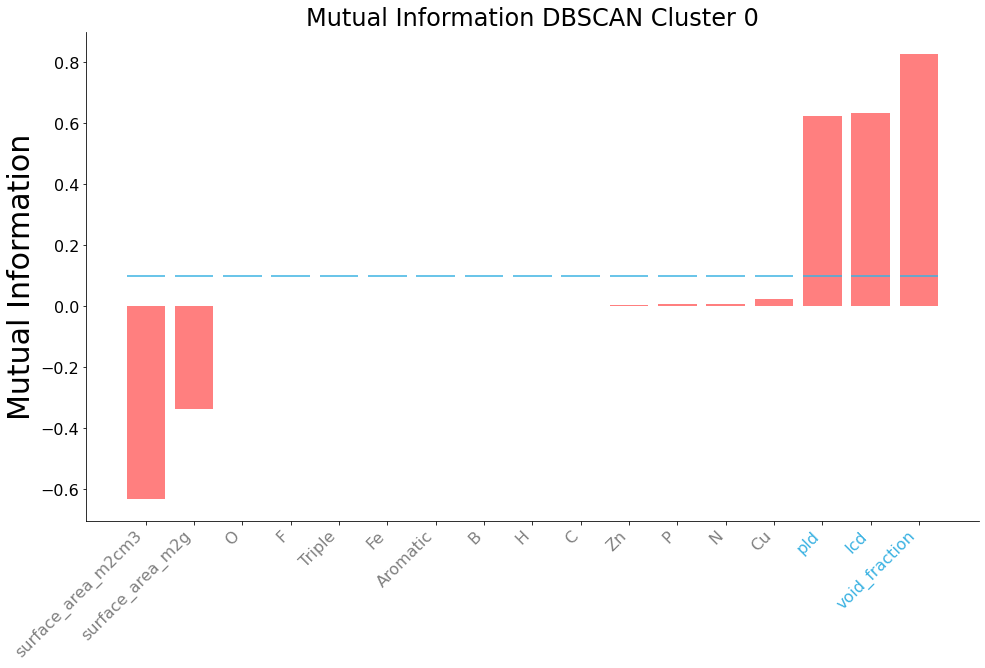

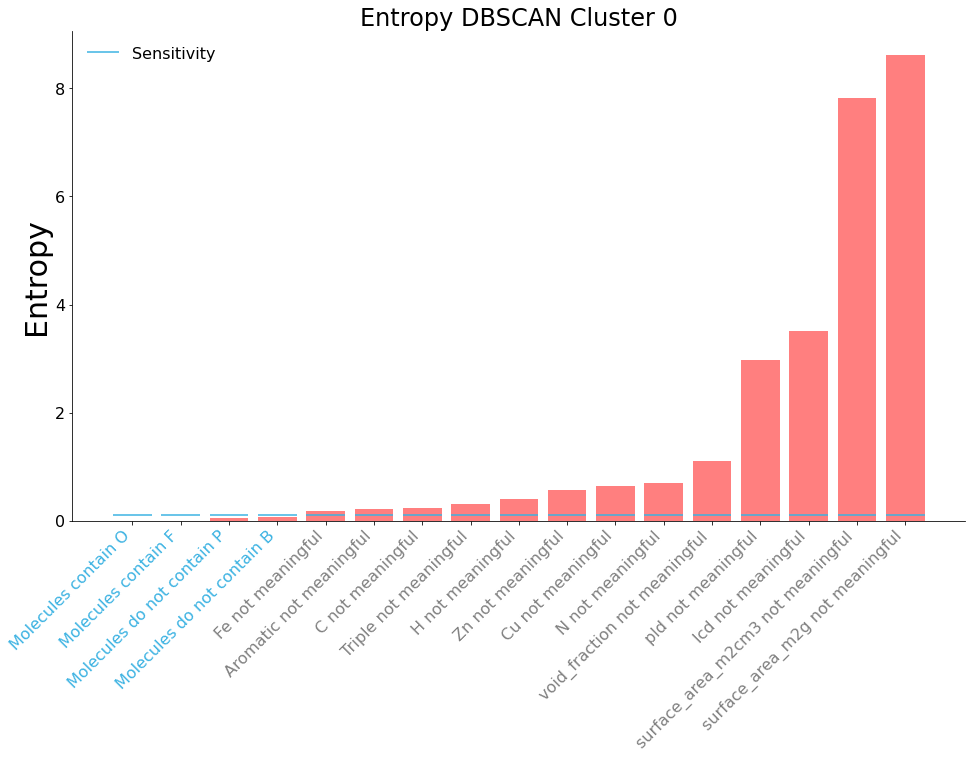

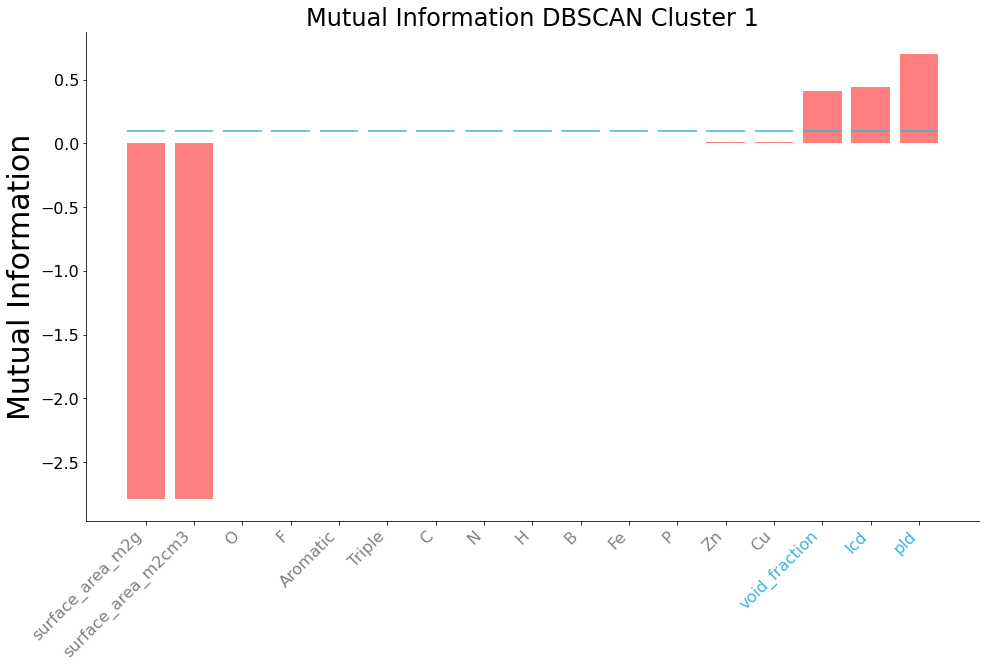

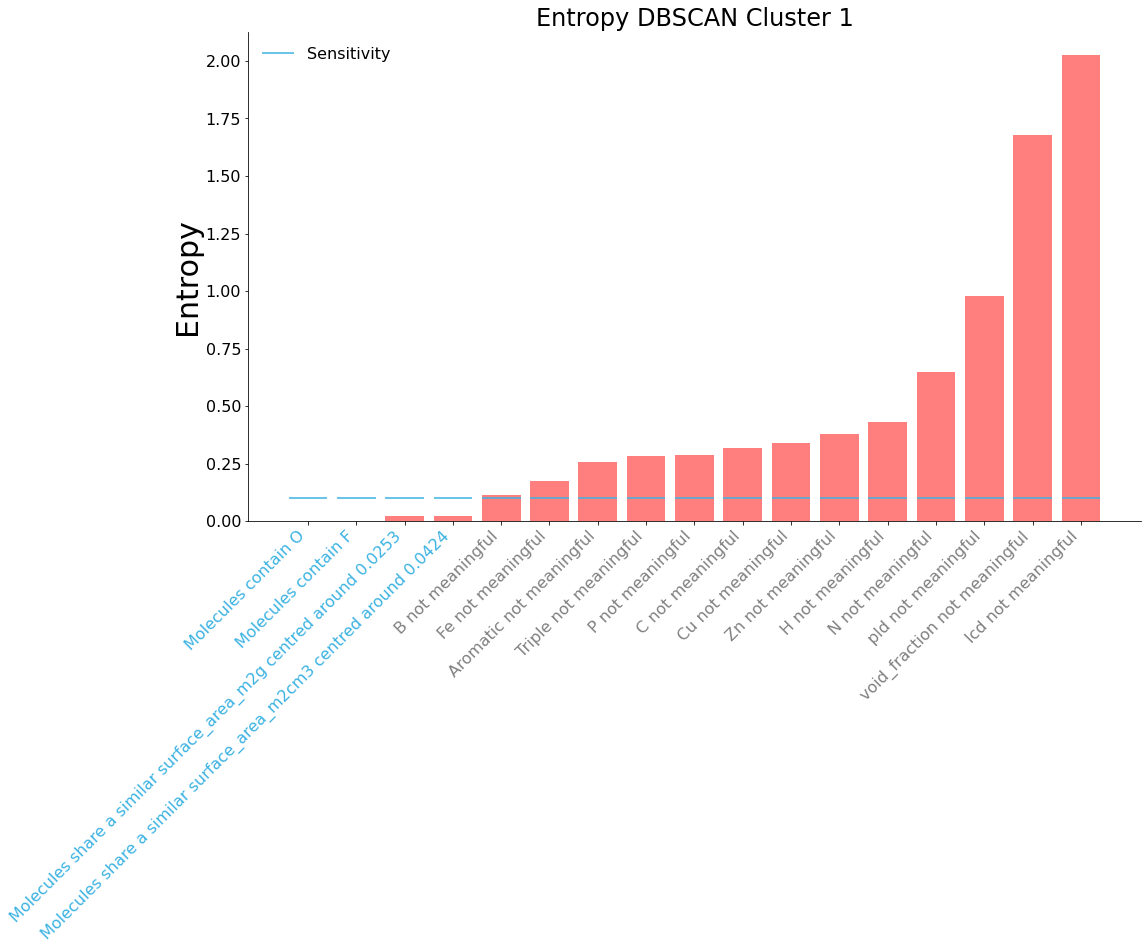

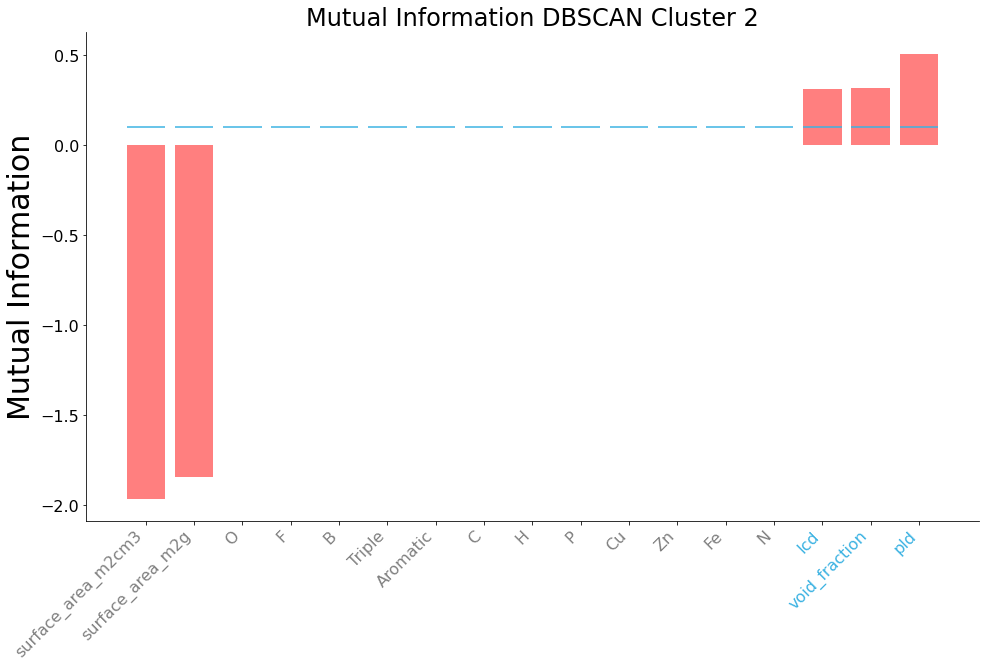

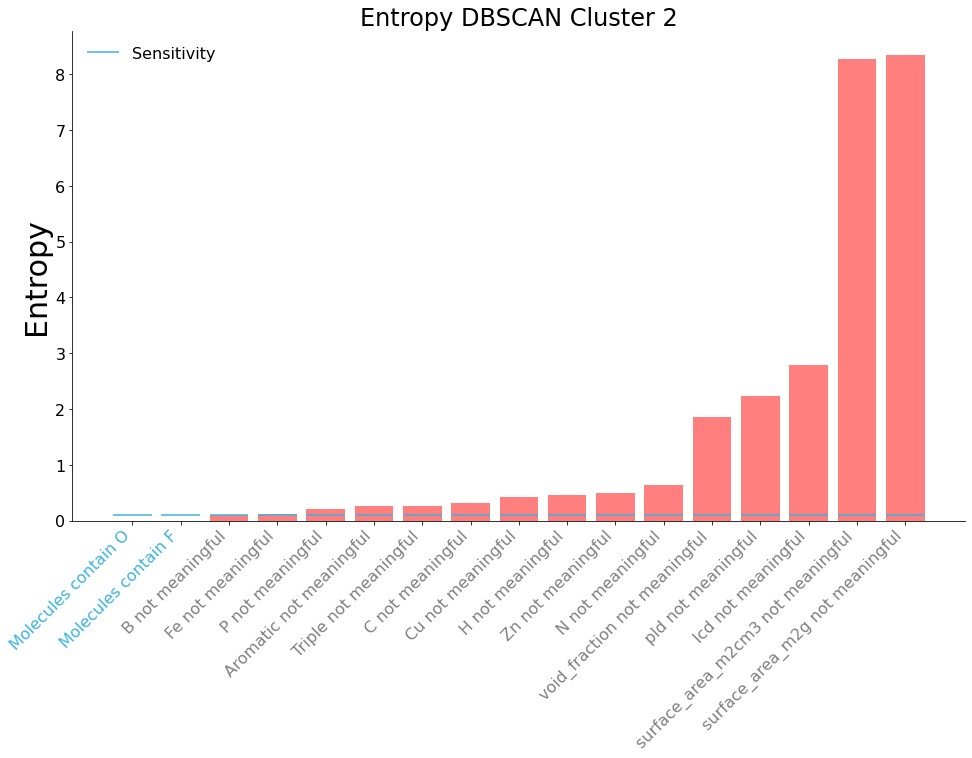

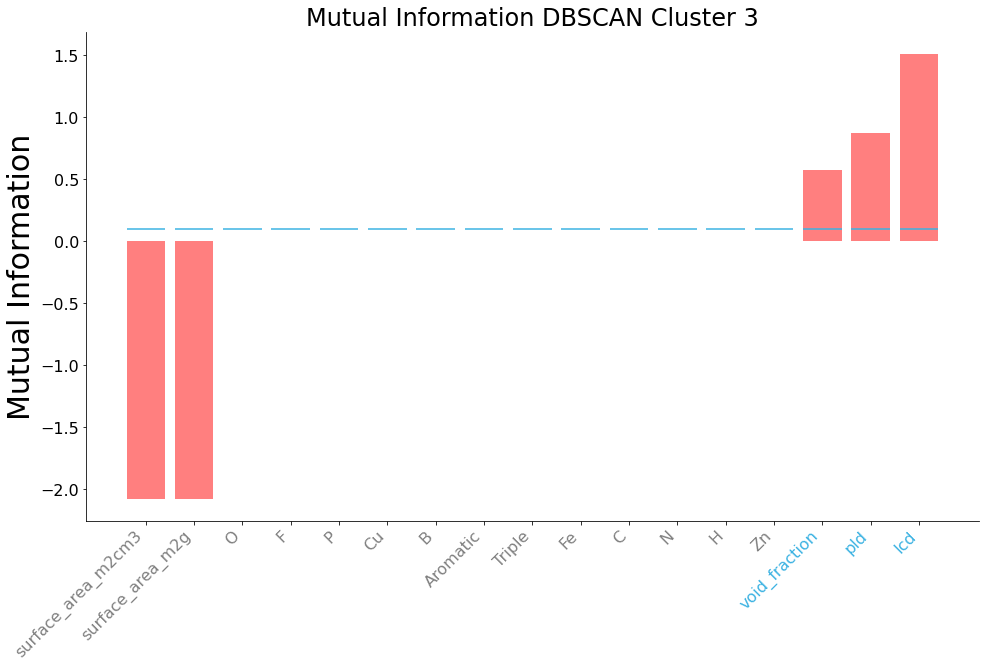

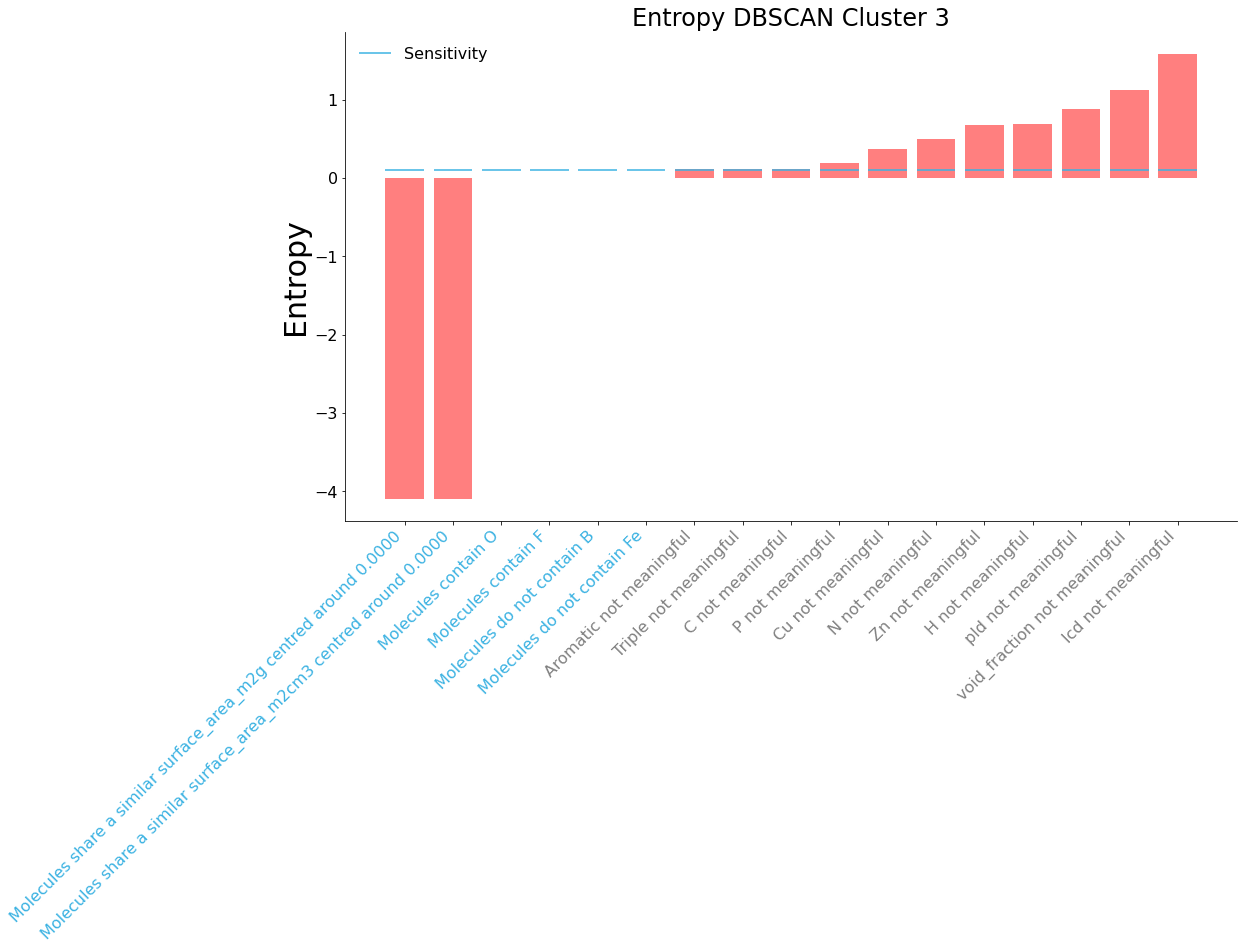

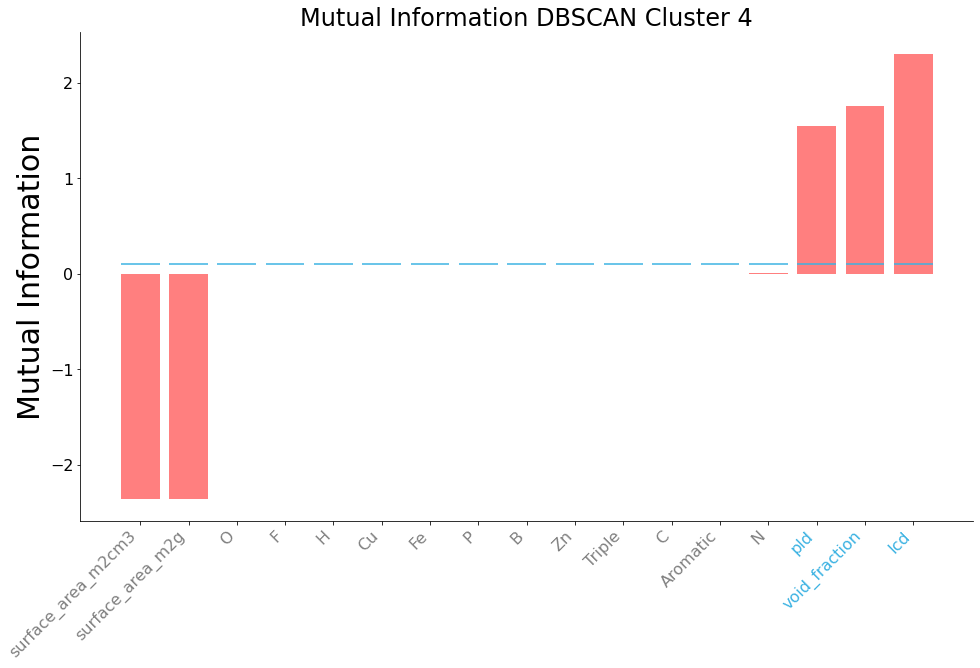

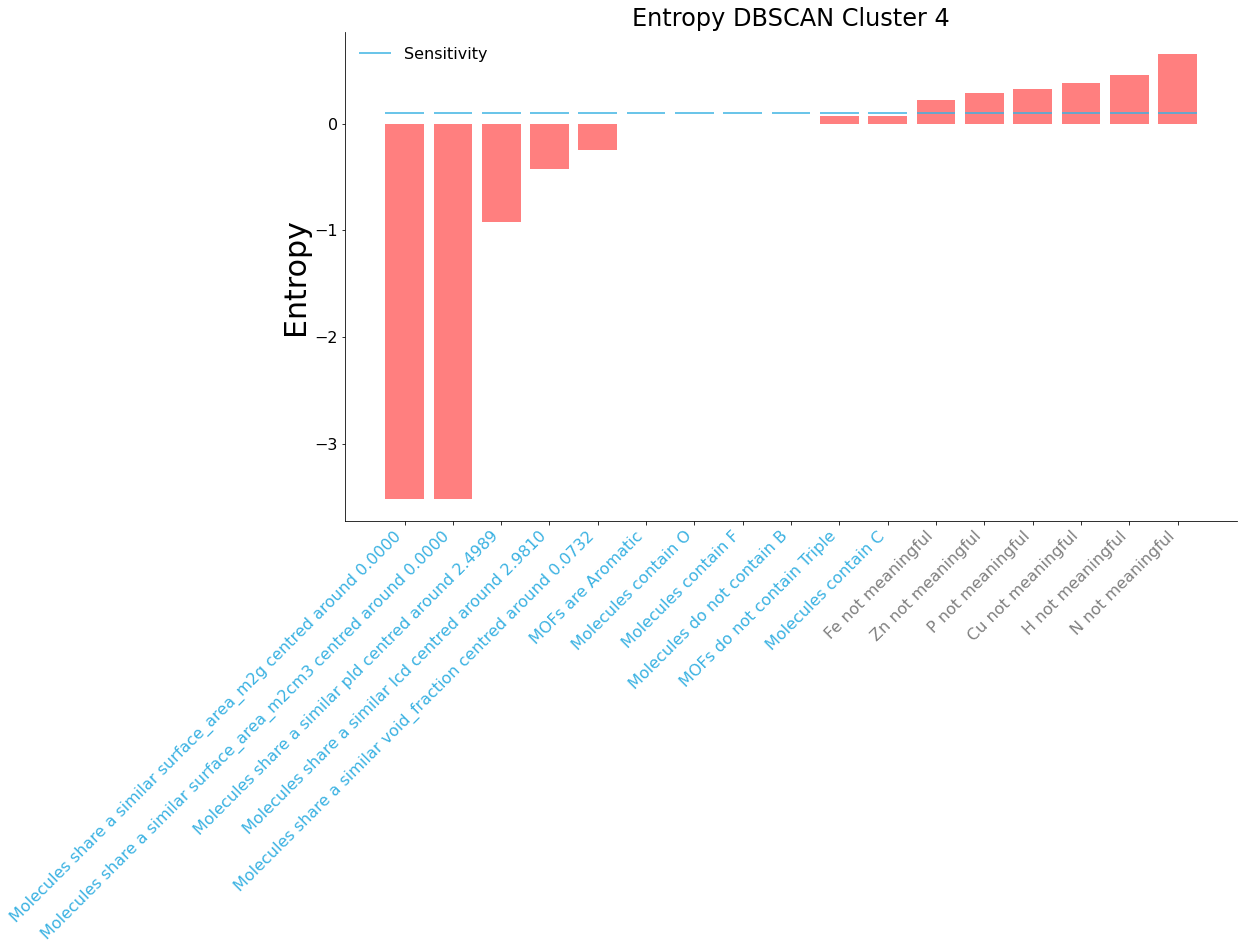

In [137]:
for i in range(5):
    space.plot_mi("DBSCAN",set_val=i)
    plt.title("Mutual Information DBSCAN Cluster {}".format(i))
    plt.savefig(f"paper/SI/MOF DBSCAN Cluster {i} MI.svg",bbox_inches="tight")
    plt.show()
    space.plot_entropy("DBSCAN",set_val=i)
    plt.title(f"Entropy DBSCAN Cluster {i}")
    plt.savefig(f"paper/SI/MOF DBSCAN Cluster {i} Entropy.svg",bbox_inches="tight")
    plt.show()

In [50]:
space.mi ("DBSCAN","N",set_val=3,return_contingency=True)

(0.0004962211212547283,
 array([[   8,   32],
        [2510, 4470]]))

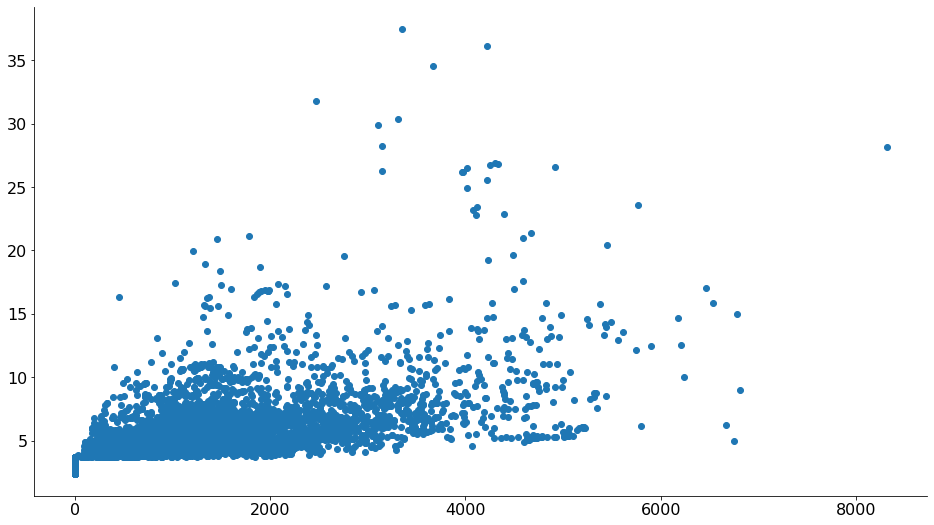

In [64]:
plt.scatter(space.data["surface_area_m2g"],space.data["pld"])

In [60]:
space.data

,void_fraction,surface_area_m2g,surface_area_m2cm3,pld,lcd,Positively Charged,Aromatic,Triple,Zn,Cu,P,O,C,N,H,F,B,Fe
0,0.691684,2862.13,1920.29,7.81880,9.99521,1,1,0,1,0,0,1,1,1,0,1,0,0
1,0.308818,0.00,0.00,2.57347,3.94915,1,1,0,0,0,1,1,1,1,0,1,0,0
2,0.606919,1293.55,1607.94,4.61872,6.46856,1,1,0,0,0,0,1,1,1,0,1,0,0
3,0.316905,0.00,0.00,2.64045,5.53566,1,1,1,0,0,0,1,1,1,0,1,0,1
4,0.503607,0.00,0.00,3.27236,6.10696,1,1,0,0,0,0,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7015,0.887222,3936.38,1925.18,9.58261,14.34300,1,1,0,0,1,0,1,1,1,0,1,0,0
7016,0.723269,1228.68,1449.57,10.81980,11.37160,1,1,0,0,0,0,1,1,1,0,1,0,0
7017,0.218833,0.00,0.00,3.35592,4.94476,1,1,0,0,0,0,1,1,1,0,1,0,0
7018,0.540490,1036.25,1197.77,7.85164,8.11716,1,1,0,0,1,0,1,1,0,1,1,1,0
